# SWaT Anomaly Detection with USAD

by dongmin kim (tommy.dm.kim@gmail.com)

In [1]:
import sys
HOME = "../../../"
sys.path.append(HOME) # repo home

In [2]:
from exp_helpers.utils import SEED_everything
SEED_everything(42)

In [3]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import easydict

## Configure settings

In [4]:
args = easydict.EasyDict({
    # general
    "dataset": "SWaT",
    "batch_size": 64,
    "lr": 1e-03,
    "window_size": 100,
    "epochs": 30,
    "use_tqdm": True,
    "tqdmopt": "notebook",
    "load_pretrained": False,

    # model-specific (USAD)
    "model": "USAD",
    "latent_dim": 128,

    # others
    "device": torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
})

In [5]:
config = ""
config += f"_dataset_{args.dataset}" \
          f"_batch_size_{args.batch_size}" \
          f"_lr_{args.lr}" \
          f"_window_size_{args.window_size}" \

config += f"_model_{args.model}" \
          f"_latent_dim_{args.latent_dim}" \

args.config = config

In [6]:
# PATH to save model
os.makedirs(os.path.join(HOME, "models", "checkpoints", f"{args.config}"), exist_ok=True)
args.model_path = os.path.join(HOME, "models", "checkpoints", f"{args.config}", "model.pt")

# PATH to save result figures
os.makedirs(os.path.join(HOME, "results"), exist_ok=True)
os.makedirs(os.path.join(HOME, "results", args.model), exist_ok=True)
os.makedirs(os.path.join(HOME, "results", args.model, args.config), exist_ok=True)
args.result_path = os.path.join(HOME, "results", args.model, args.config)
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(args.model_path)
print(args.result_path)

../../../models/checkpoints/_dataset_SWaT_batch_size_64_lr_0.001_window_size_100_model_USAD_latent_dim_128/model.pt
../../../results/USAD/_dataset_SWaT_batch_size_64_lr_0.001_window_size_100_model_USAD_latent_dim_128


## Load data

In [7]:
from data.load_data import load_data
from data.dataset import get_dataset

train_x, train_y, test_x, test_y = load_data(args.dataset, HOME)

train_dataset = get_dataset(train_x, train_y, window_size = args.window_size, dataset_type=args.dataset)
test_dataset = get_dataset(test_x, test_y, window_size = args.window_size, dataset_type=args.dataset)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_dataset,
                 batch_size=args.batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_dataset,
                batch_size=args.batch_size,
                shuffle=False)

args.input_dim = train_x.shape[1]

Reading SWaT...
current location: /home/nas3_userJ/dmkim/TSAD/notebooks/Modeling/SWaT
home dir: ../../../
Loading complete.


## Model

In [8]:
from models.utils import prepare_model, prepare_loss_fn
print(f"setting model to {args.device}...")
model = prepare_model(args)
model.to(args.device)

setting model to cuda...


USAD(
  (encoder): Encoder(
    (linear1): Linear(in_features=51, out_features=25, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=25, out_features=12, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=12, out_features=128, bias=True)
    (relu3): ReLU()
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=128, out_features=12, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=12, out_features=25, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=25, out_features=51, bias=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=128, out_features=12, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=12, out_features=25, bias=True)
    (relu2): ReLU()
    (linear3): Linear(in_features=25, out_features=51, bias=True)
    (sigmoid): Sigmoid()
  )
)

In [9]:
from exp_helpers.exp_USAD import USAD_Trainer

if args.load_pretrained is True:
    print(f"loading pretrained model at {args.model_path}...")
    best_model = model
    best_model.load_state_dict(torch.load(args.model_path))
    best_model.to(args.device)
    print("done")
else:
    print("start training...")
    optimizer = torch.optim.Adam(params=model.parameters(), lr = args.lr)
    loss_fn = prepare_loss_fn(args)

    trainer = USAD_Trainer(
        args=args,
        model=model,
        train_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )

    best_model = trainer.train()

start training...
{'dataset': 'SWaT', 'batch_size': 64, 'lr': 0.001, 'window_size': 100, 'epochs': 30, 'use_tqdm': True, 'tqdmopt': 'notebook', 'load_pretrained': False, 'model': 'USAD', 'latent_dim': 128, 'device': device(type='cuda'), 'config': '_dataset_SWaT_batch_size_64_lr_0.001_window_size_100_model_USAD_latent_dim_128', 'model_path': '../../../models/checkpoints/_dataset_SWaT_batch_size_64_lr_0.001_window_size_100_model_USAD_latent_dim_128/model.pt', 'result_path': '../../../results/USAD/_dataset_SWaT_batch_size_64_lr_0.001_window_size_100_model_USAD_latent_dim_128', 'input_dim': 51}


  0%|          | 0/30 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

training:   0%|          | 0/7761 [00:00<?, ?it/s]

In [10]:
from exp_helpers.exp_USAD import USAD_Tester

tester = USAD_Tester(
    args = args,
    model = best_model,
    train_loader = train_loader,
    test_loader = test_loader,
)

train iterator:   0%|          | 0/7761 [00:00<?, ?it/s]

test iterator:   0%|          | 0/7029 [00:00<?, ?it/s]

In [11]:
from data.load_data import load_anomaly_intervals

In [12]:
anomaly_scores = tester.get_anomaly_score()

/home/nas3_userJ/dmkim/anaconda3/envs/TSAD/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


=== Anomaly statistics ===
Total: 449820
mean[0.03884221240878105], median[0.03342754393815994], min[0.016942348331212997], max[0.21271397173404694]


In [13]:
intervals = load_anomaly_intervals(anomaly_labels = test_y, window_size = args.window_size)

finding best threshold...
done.
plotting metrics...


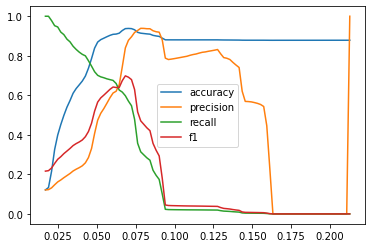

plotting anomaly scores with thresholds...


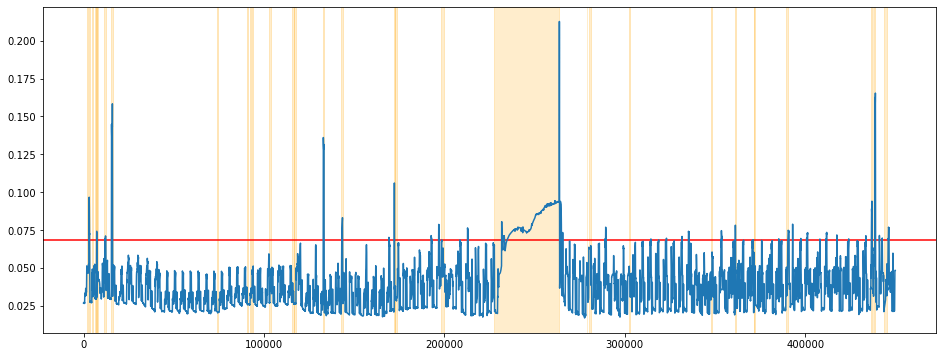

plotting final statistics...
best threshold: 0.06835711811377546
accuracy: 0.9373593881997243 precision 0.8397972051367836 recall 0.5978308661878939 f1 0.698451429244122


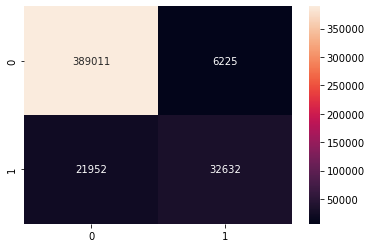

In [14]:
best_threshold = tester.regular_thresholding(test_y, anomaly_scores, intervals, num_candidates = 100)